# <a name="content_list">Home work I (Part I)</a>
   1. [Importing modules](#importing_modules)
   2. [Simple features analysing](#features_analysing)
       1. [Age](#age)
       2. [Distance](#distance)
           1. [Haversine function](#haversine_function)
       3. [Average square footage](#average_sqft)
       4. [Square footage of all basements](#all_basement_sqft)
       5. [Date](#date)
       6. [Renovation square footage difference](#sqft_15_diff)
   3. [Clustering](#clustering)
       1. [Districts](#districts)
           1. [Districts clustering by price](#d_clustering_by_price)
           2. [Districts clustering by location](#d_clustering_by_location)
       2. [Neighborhoods](#neighborhoods)
           1. [Neigborhoods clustering by price](#n_clustering_by_price)
           2. [Neigborhoods clustering by location](#n_clustering_by_price)
   4. [Linear regression](#linear_regression)
       1. [Features usefulness analys](#features_usefulness_analys)
           1. [Useless feature](#useless_feature)
           2. [Usefull feature](#usefull_feature)
       2. [Linear regression result](#lr_prediction_result)
   5. [Decision tree](#decision_tree)
       1. [Decision tree result](#dt_result)
   6. [Summary](#summary)
       
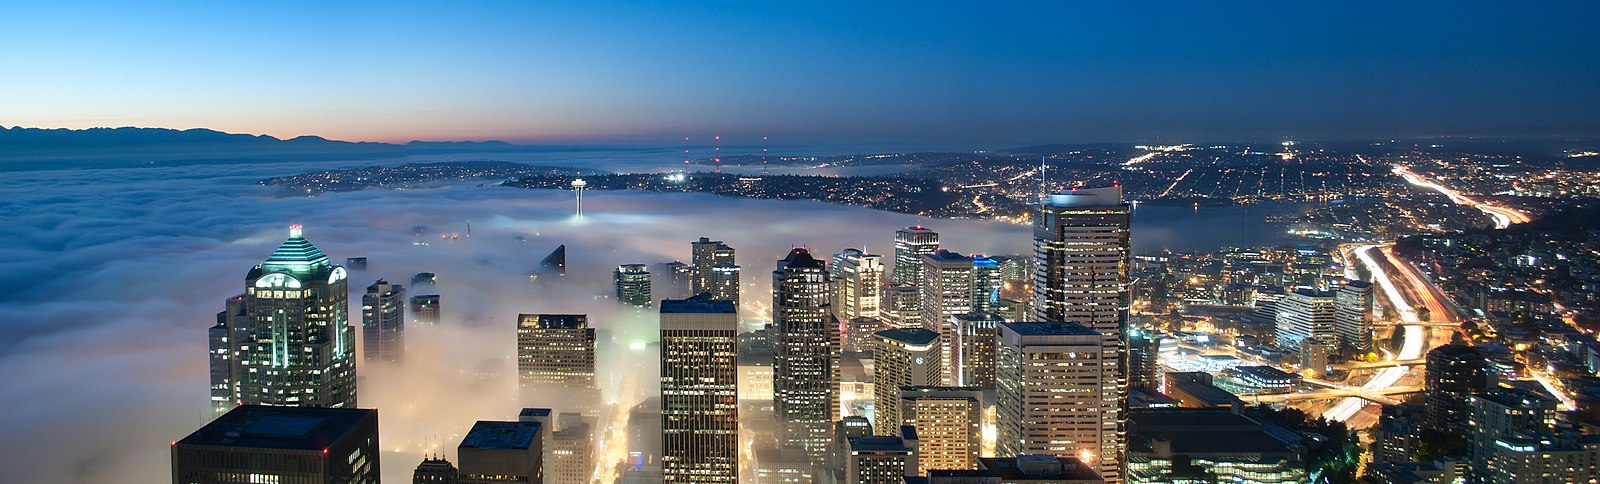

picture from: https://en.wikipedia.org/wiki/File:Seattle_Columbia_Pano2.jpg

Course: Introduction in machine learning

Lecturer: Taras Lehinevych

Author: Kyryll Vasylenko

# <a name="importing_modules">Importing modules, dataset initializing</a>

[Back to content list](#content_list)

In [1]:
# Importing
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import mpl_toolkits as mpl_toolkits
from math import radians, cos, sin, asin, sqrt, log
from datetime import datetime
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
#for decision tree
from sklearn.tree import DecisionTreeRegressor
#for clustering\graphics
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

# Dataset reading
frame = pd.read_csv('house_data.csv')

# <a name="features_analysing">Features analysing</a>

[Back to content list](#content_list)

In [2]:
frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
id               21613 non-null int64
date             21613 non-null object
price            21613 non-null float64
bedrooms         21613 non-null int64
bathrooms        21613 non-null float64
sqft_living      21613 non-null int64
sqft_lot         21613 non-null int64
floors           21613 non-null float64
waterfront       21613 non-null int64
view             21613 non-null int64
condition        21613 non-null int64
grade            21613 non-null int64
sqft_above       21613 non-null int64
sqft_basement    21613 non-null int64
yr_built         21613 non-null int64
yr_renovated     21613 non-null int64
zipcode          21613 non-null int64
lat              21613 non-null float64
long             21613 non-null float64
sqft_living15    21613 non-null int64
sqft_lot15       21613 non-null int64
dtypes: float64(5), int64(15), object(1)
memory usage: 3.5+ MB


#### <a name="age">Age</a>

Age of house starting from renovation date or if house wasn't renovated - staring from year of building

As we can see, yr_renovated has 0 values, so, we can replase them with yr_build values and with formula below we will have house age

age = yr_renovated - current_year

In [3]:
current_year = datetime.now().year
for i, x in frame[['yr_built']].itertuples():
    if(frame.at[i, 'yr_renovated'] == 0):
        frame.at[i, 'yr_renovated'] = x
    frame.at[i, 'age'] = current_year - frame.at[i, 'yr_renovated']

#### <a name="distance">Distance</a>

Let's get from lot and lang coordinate and count distance from center of Seattle!

My conclusion - than house farther from the center, than house price lower.

##### <a name="haversine_function">Haversine auxiliary function</a>
*Calculates the great circle distance between two points 
on the earth (specified in decimal degrees)*

$long$ - Longitude

$lat$ - Latitude

$r = 6371$ - Earth radius in kilometers

$\Delta lat = {lat_2 - lat_1} $

$\Delta long = {long_2 - long_1} $

**haversine** = $2r\arcsin{(\sqrt{\sin^2{(\frac{\Delta lat}{2})} + \cos{(lat_1)} \cos{(lat_2)} \sin^2{(\frac{\Delta long}{2})}})}$

In [4]:
def haversine(lon2, lat2):
    # Seattle center coordinates
    centerLon = -122.352033
    centerLat = 47.622451

    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [centerLon, centerLat, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers, 3956 for miles
    return c * r

In [5]:
for i, lat, long in frame[['lat','long']].itertuples():
    frame.at[i,'distance'] = haversine(long, lat)

#### <a name="average_sqft">Average square footage</a>

If house has average square footage by room or by floor n, this house can be worst than house with average square footage m, where m > n

In [6]:
for i, f, a, b, c, d in frame[['floors','bedrooms','bathrooms','sqft_above','sqft_basement']].itertuples():
    frame.at[i,'average_sqft_by_room'] = ((c+d)/((a+b)+1))#+1 because house can be without bedrooms or bathrooms
    frame.at[i,'average_sqft_by_floor'] = ((c+d)/f)

#### <a name="all_basement_sqft">All basements square footage</a>

We have sqft_basement field - information about house basement, we also have house floors count, we can multiply this parameters and get house sqft for all floors

Suggestion: Than more floors, than biggest price of house

In [7]:
for i, f, sqft in frame[['floors','sqft_basement']].itertuples():
    frame.at[i,'sqft_floors_mult_basement'] = f*sqft

#### <a name="date">Date</a>

- We can't create regression by date object
- Sales starts in 2014 year
- Not effective convert date to millis or seconds or days, because generally house prices can't change each second or each day
- Each year - too large
- Each month - sounds good

In [8]:
frame['date'] = pd.to_datetime(frame['date'])
for i, d in frame[['date']].itertuples():
    frame.at[i, 'mnths'] = (d.year - 2014)*12 + d.month

#Delete useless field
del frame['date']

#### <a name="sqft_15_diff">Square footage difference</a>

Created difference between sqft in 15 year and sqft living.

We have some result of reonvation for sque.

In [9]:
#Convert difference between sqft_living15 and sqft_living to ren_living_diff - sqft difference after renovation 
for i, l, lo, l15, lo15 in frame[['sqft_living','sqft_lot','sqft_living15','sqft_lot15']].itertuples():
    frame.at[i,'ren_living_diff'] = l15-l
    frame.at[i,'ren_lot_diff'] = lo15-lo

# <a name="clustering">Clustering</a>

[Back to content list](#content_list)

## <a name="districts">Districts</a>

- Seattle has 7 districts
- So, I will split lots into seven clusters by coordinates
    - Firstly I will split into clasters by location
    - And I will split by price and distance, I think, can be price correlation by ditance from center
    
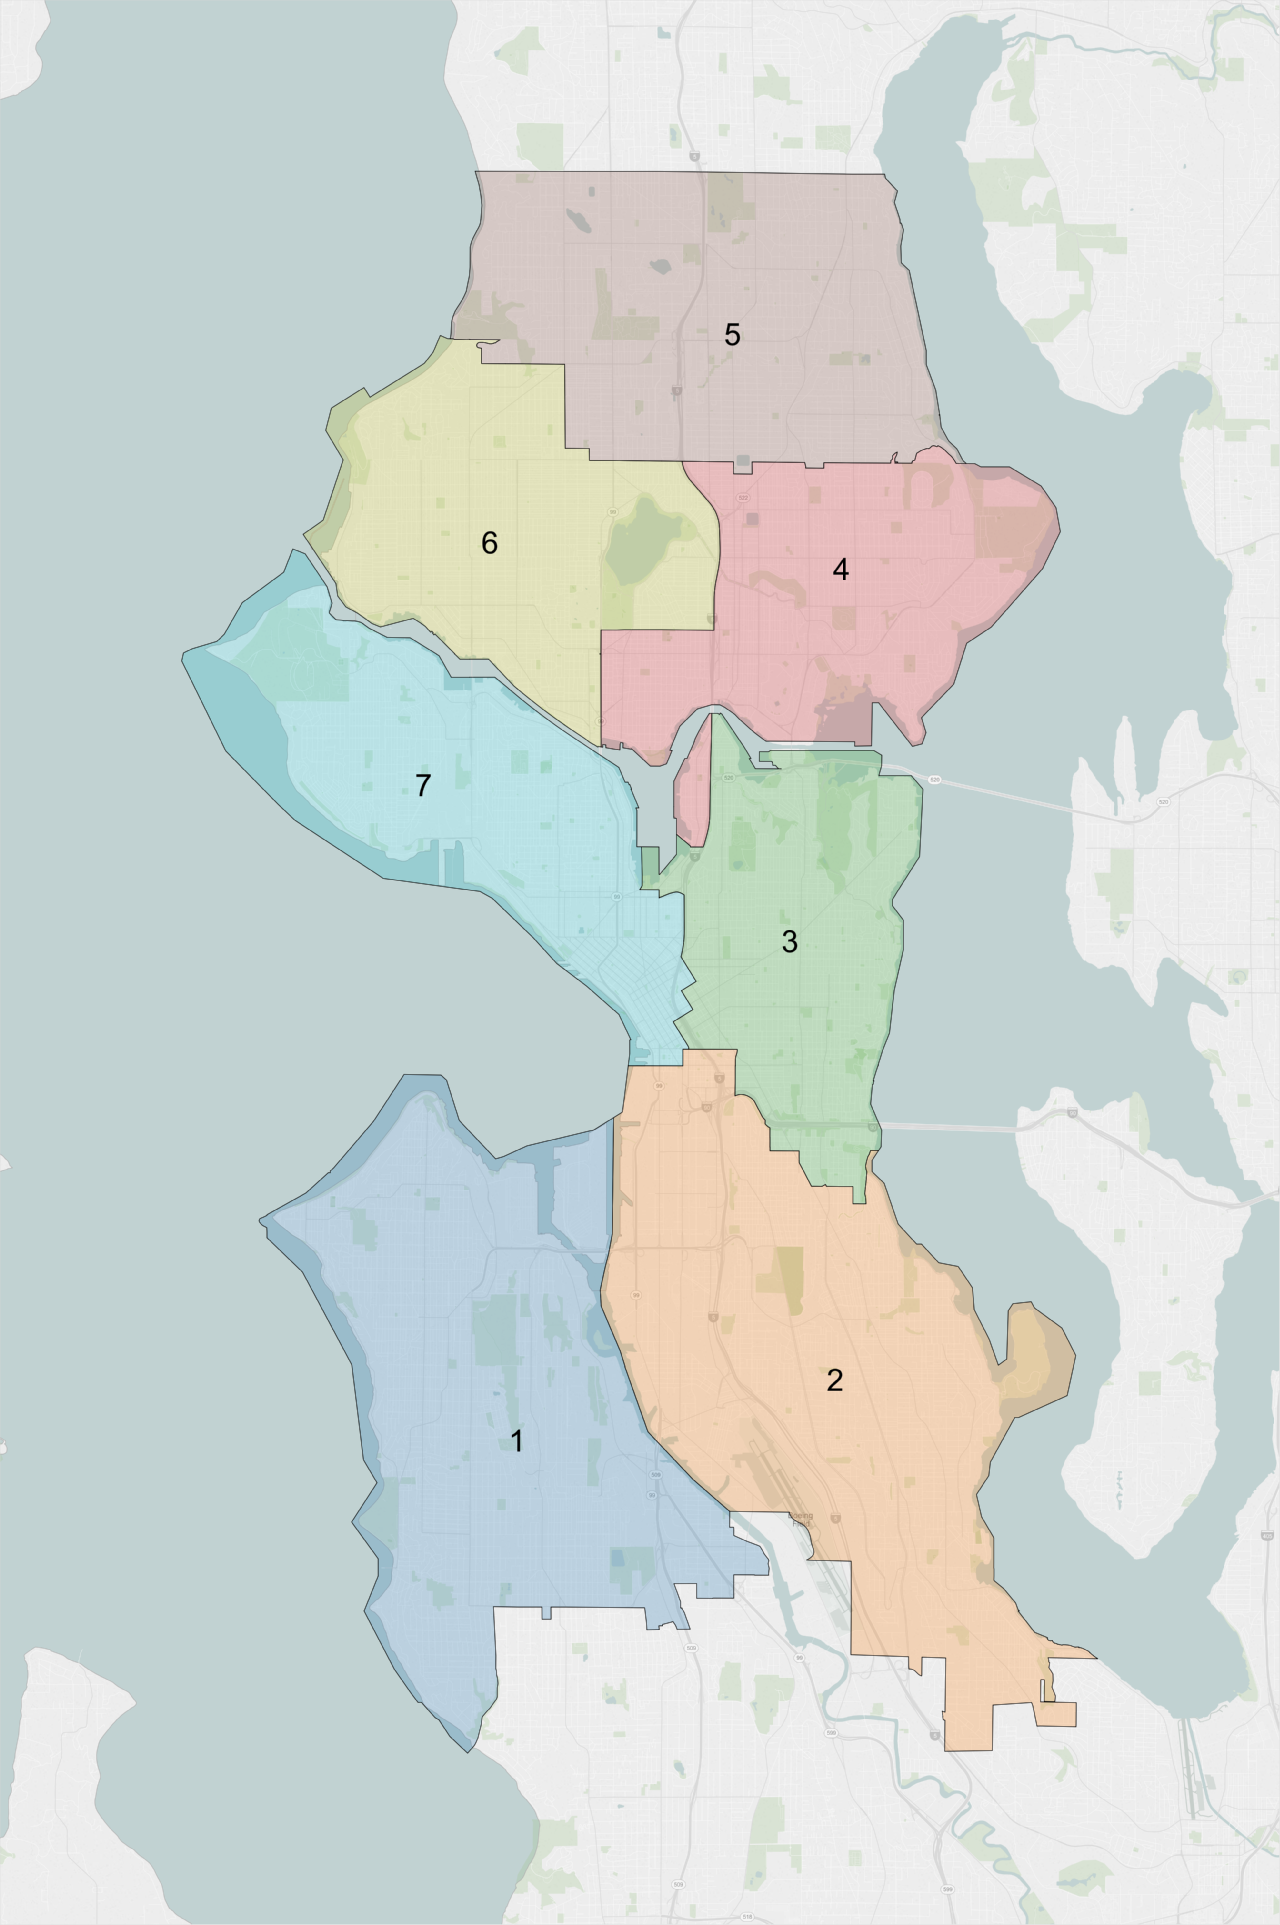

picture from: https://en.wikipedia.org/wiki/Seattle

[Back to content list](#content_list)

# <a name="d_clustering_by_price">Districts clustering by price</a>

[Back to content list](#content_list)

In [10]:
# Simple points visualization by x and y coordinates
def draw(x, y):
    data = frame[[x,y]].values
    plt.scatter(data[:, 0], data[:, 1], s=5, alpha=.4)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.show()
    return data

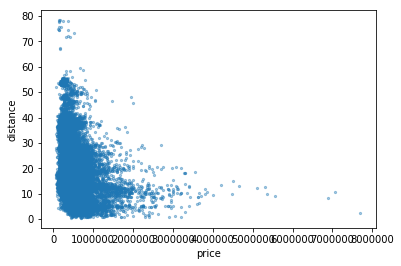

In [11]:
# Distance by price visualization
dist_price = draw('price','distance')

In [12]:
# Train and centers initializing
k_means_district = KMeans(n_clusters=7)
k_means_district.fit(dist_price)
centers = k_means_district.cluster_centers_

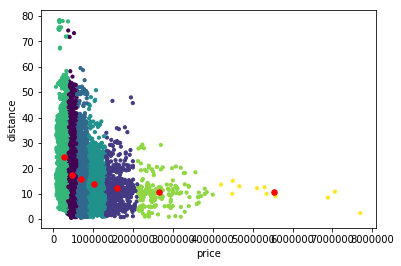

In [13]:
# Districts clustering by price visualization
plt.xlabel("price")
plt.ylabel("distance")
plt.scatter(dist_price[:, 0], dist_price[:, 1], c=k_means_district.predict(dist_price), s=10, alpha=1)
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=30, alpha=1)

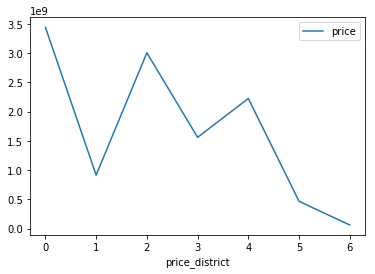

In [14]:
# Splitting lots into districts
distance_clusters = k_means_district.predict(dist_price)
for i, d in frame[['distance']].itertuples():
    frame.at[i,'price_district'] = distance_clusters[i]
    
pd.DataFrame({
    'price': frame['price'],
    'price_district': frame['price_district']
    }).groupby('price_district').sum().plot()

# <a name="d_clustering_by_location">Districts clustering by location</a>

[Back to content list](#content_list)

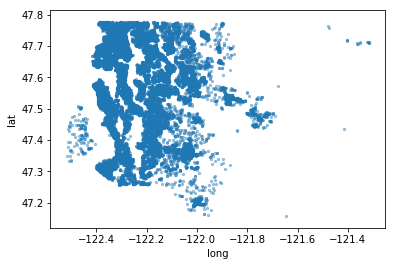

In [15]:
# Coordinates visualization
coordinates = draw('long','lat')

In [16]:
# Train and centers initialization 
k_means_district.fit(coordinates)
centers = k_means_district.cluster_centers_

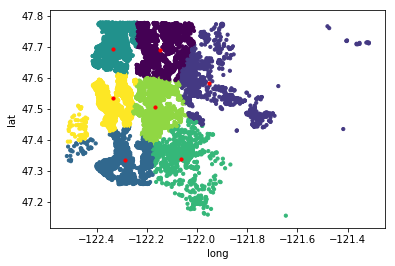

In [17]:
plt.xlabel("long")
plt.ylabel("lat")
plt.scatter(coordinates[:, 0], coordinates[:, 1], c=k_means_district.predict(coordinates), s=10, alpha=1)
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=10, alpha=1)

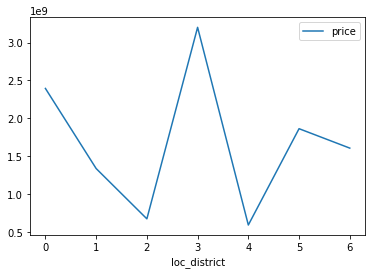

In [18]:
# Splitting lots into districts
loc_clusters = k_means_district.predict(coordinates)
for i, lat, long in frame[['lat','long']].itertuples():
    frame.at[i,'loc_district'] = loc_clusters[i]
pd.DataFrame({
    'price': frame['price'],
    'loc_district': frame['loc_district']
    }).groupby('loc_district').sum().plot()

# <a name="neighborhoods">Neighborhoods</a>

- And also Seattle has 127 neighborhoods
- So, I will split coordinates into 127 clusters, because clustering by neighborhoods can give us more presicion than clustering by districts
    - Split into clasters by location
    - Split by price
    
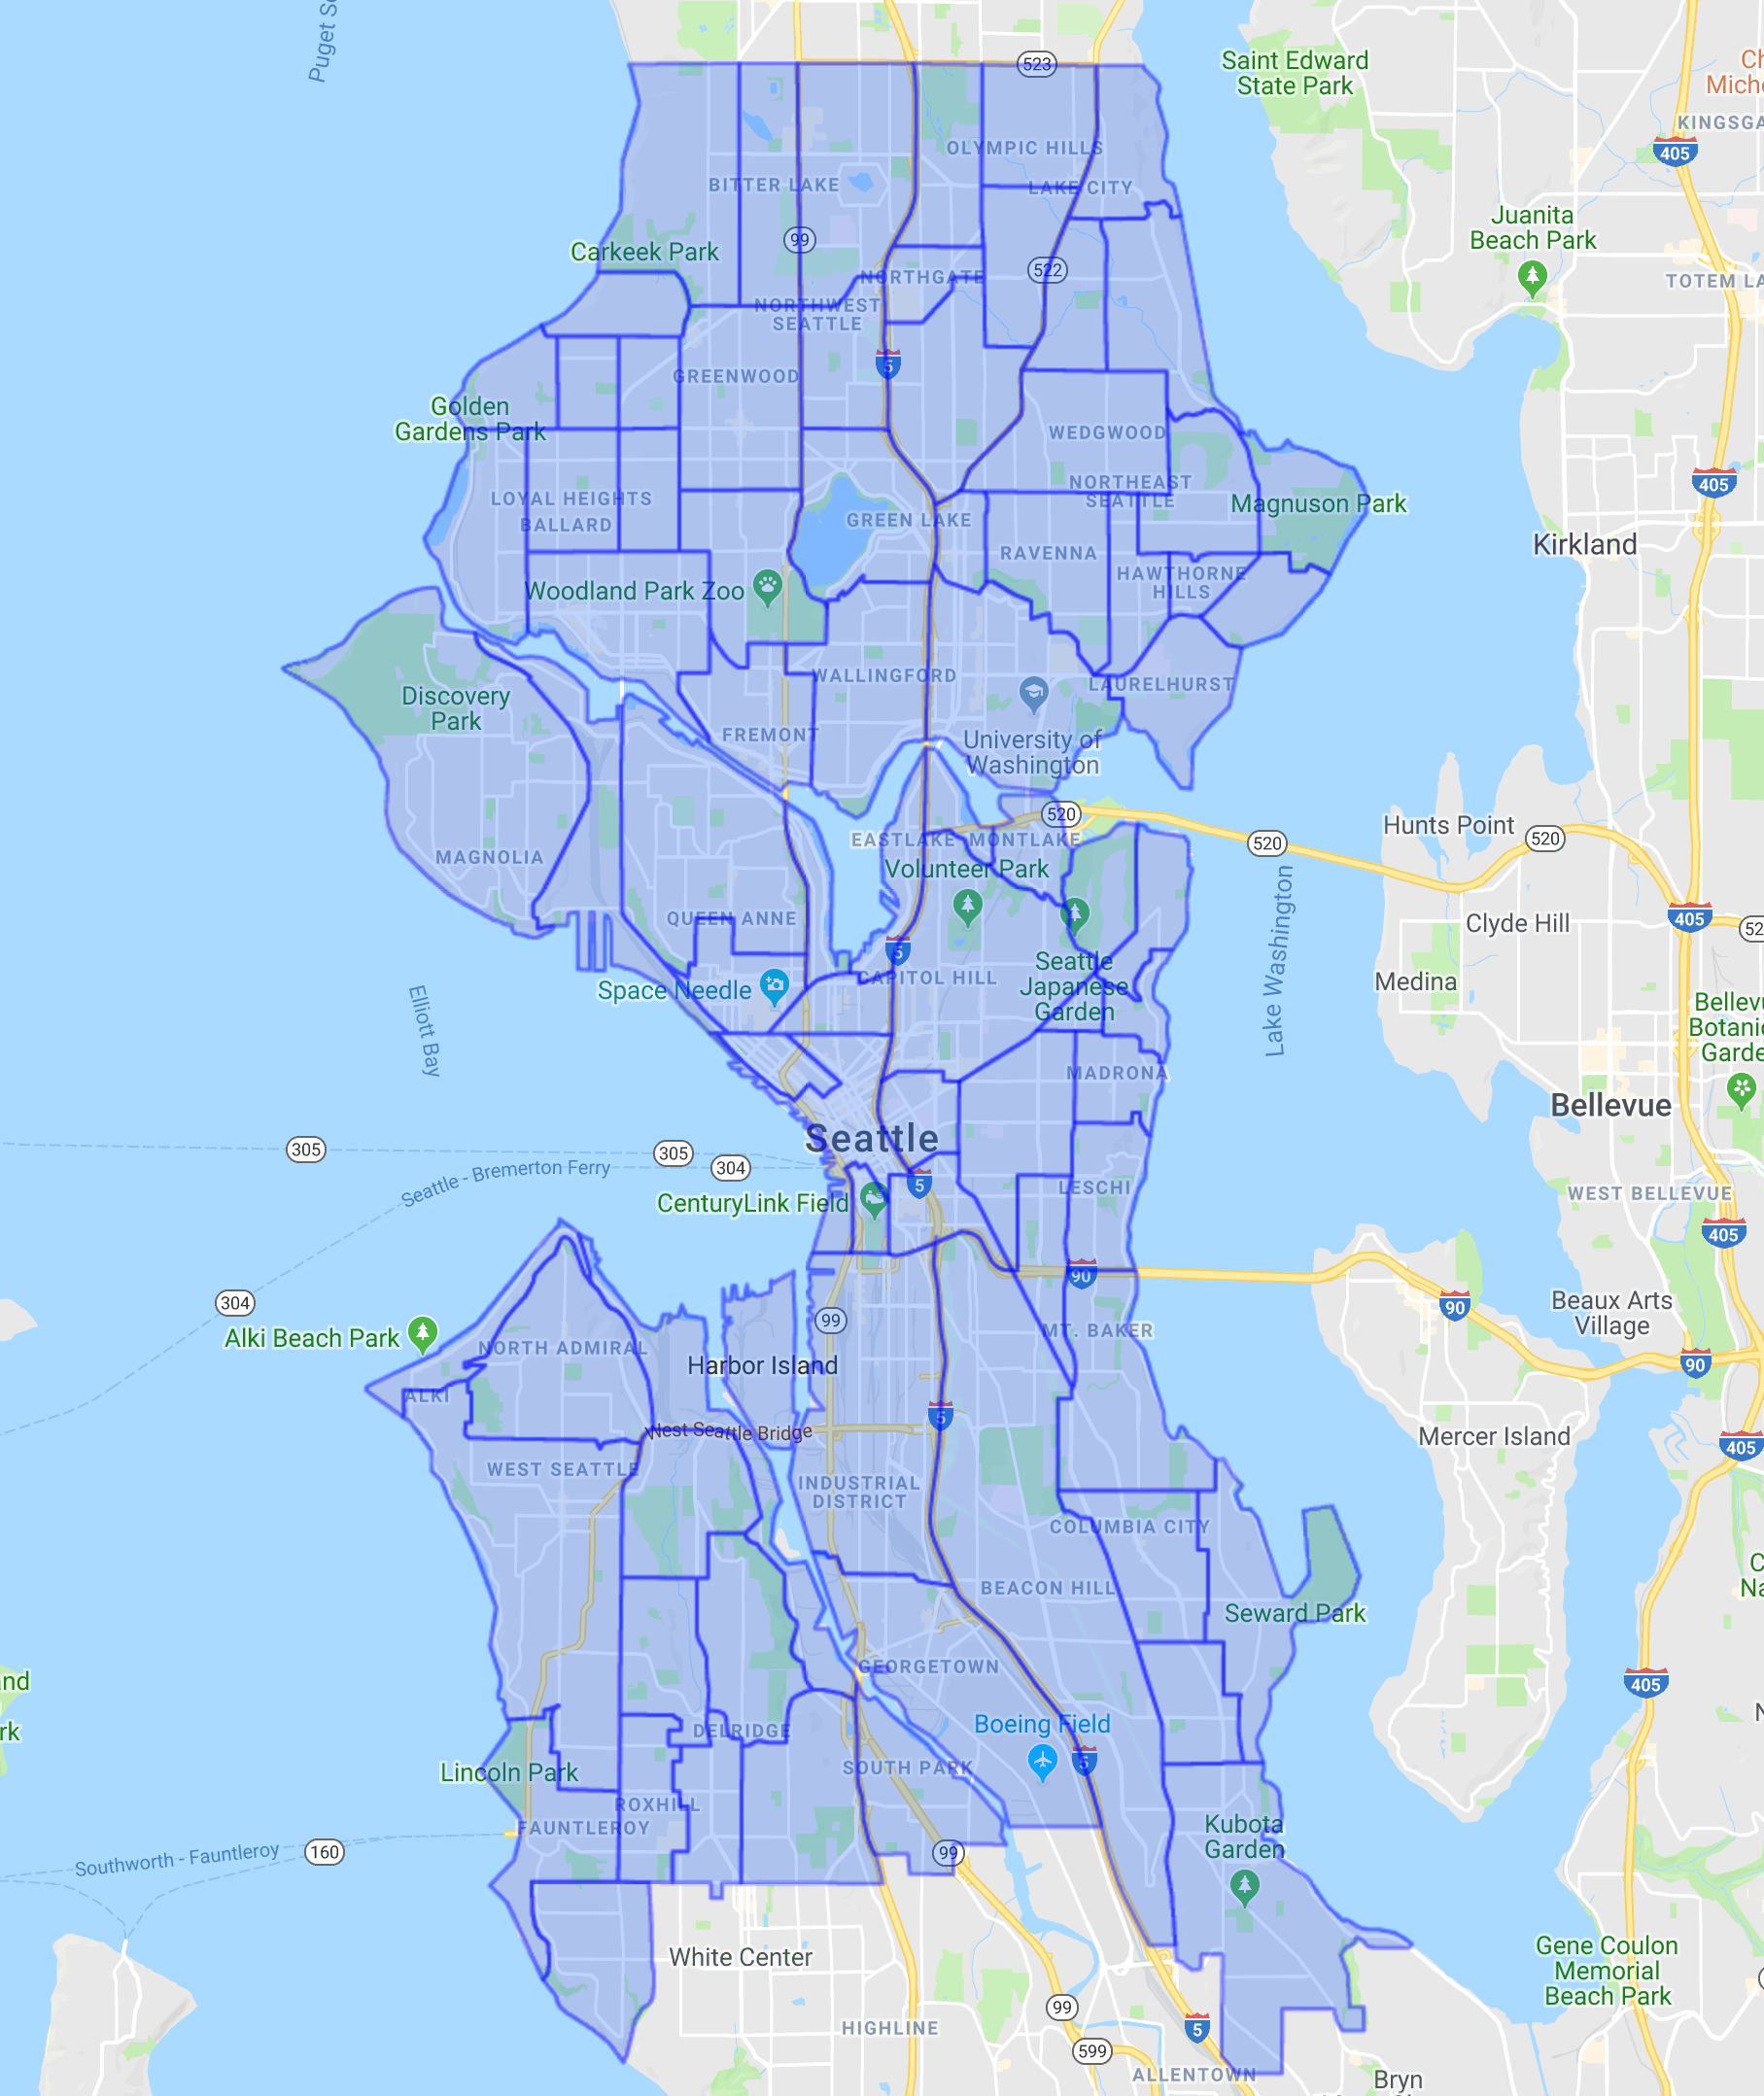
picture from: https://seattle.findwell.com/seattle-neighborhoods/
    
[Back to content list](#content_list)

## <a name="n_clustering_by_price">Neigborhoods clustering by price</a>

[Back to content list](#content_list)

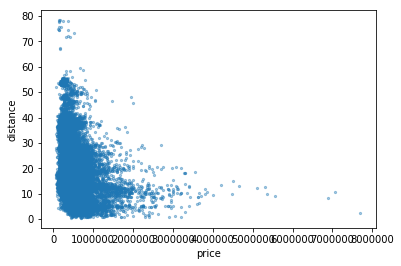

In [19]:
# Distance by price visualization
dist_price = draw('price','distance')

In [20]:
# Train and centers initializing
k_means_neighborhoods = KMeans(n_clusters=127)
k_means_neighborhoods.fit(dist_price)
centers = k_means_neighborhoods.cluster_centers_

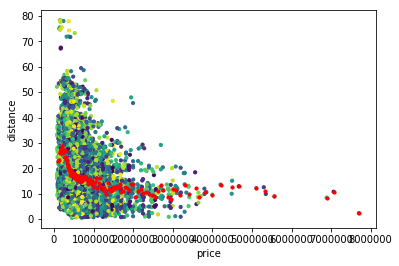

In [21]:
# Neigborhoods clustering by price visualization
plt.xlabel("price")
plt.ylabel("distance")
plt.scatter(dist_price[:, 0], dist_price[:, 1], c=k_means_neighborhoods.predict(dist_price), s=10, alpha=1)
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=10, alpha=1)

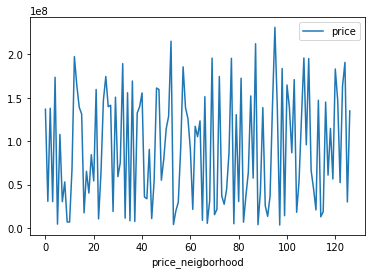

In [22]:
# Splitting lots into neigborhoods
distance_clusters = k_means_neighborhoods.predict(dist_price)
for i, d in frame[['distance']].itertuples():
    frame.at[i,'price_neigborhood'] = distance_clusters[i]

#Visualisation
pd.DataFrame({
    'price': frame['price'],
    'price_neigborhood': frame['price_neigborhood']
    }).groupby('price_neigborhood').sum().plot()

## <a name="n_clustering_by_price">Neigborhoods clustering by location</a>

[Back to content list](#content_list)

In [23]:
# Train and centers initialization
k_means_neighborhoods.fit(coordinates)
centers = k_means_neighborhoods.cluster_centers_

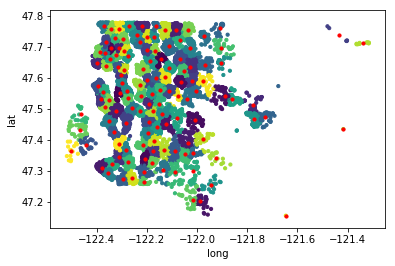

In [24]:
plt.xlabel("long")
plt.ylabel("lat")
plt.scatter(coordinates[:, 0], coordinates[:, 1], c=k_means_neighborhoods.predict(coordinates), s=10, alpha=1)
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=10, alpha=1)

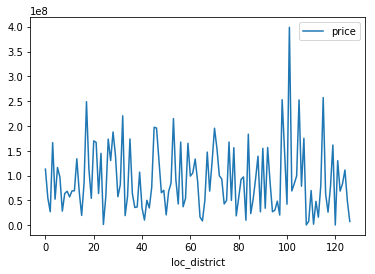

In [25]:
# Splitting lots into neighborhoods
loc_clusters = k_means_neighborhoods.predict(coordinates)
for i, lat, long in frame[['lat','long']].itertuples():
    frame.at[i,'loc_district'] = loc_clusters[i]
pd.DataFrame({
    'price': frame['price'],
    'loc_district': frame['loc_district']
    }).groupby('loc_district').sum().plot()

# <a name="linear_regression">Linear Regression</a>

[Back to content list](#content_list)

In [26]:
# Create linear regression object
regr = linear_model.LinearRegression()

In [27]:
def split(frame, features_columns, target_column):
    # Split the frame into training/testing sets
    train_frame, test_frame = train_test_split(frame, test_size = 0.2, random_state=49)
    
    train_features = train_frame.iloc[:,features_columns]
    test_features = test_frame.iloc[:,features_columns]
    
    train_target = train_frame[target_column]
    test_target = test_frame[target_column]
    return train_features, train_target, test_features, test_target

In [28]:
def fit_and_test(train_features, train_target, test_features, test_target):
    regr.fit(train_features, train_target)
    train_prediction = regr.predict(train_features)
    test_prediction = regr.predict(test_features)
    
    print(":::Train:::")
    mse = mean_squared_error(train_target, train_prediction)
    r2s = r2_score(train_target, train_prediction)
    print("Mean squared error: %.2f" % mse)
    print('Variance score: %.2f' % r2s)
    
    mse = mean_squared_error(test_target, test_prediction)
    r2s = r2_score(test_target, test_prediction)
    print(":::Test:::")
    print("Mean squared error: %.2f" % mse)
    print('Variance score: %.2f' % r2s)

In [29]:
#Fit and visualisation model by single feature
def fit_and_test_visualisation(frm, feature_column, target):
    train_features, train_target, test_features, test_target = split(frame, feature_column, target)
    
    regr.fit(train_features, train_target)
    train_prediction = regr.predict(train_features)
    test_prediction = regr.predict(test_features)
    
    print('Feature # {} : {}'.format(feature_column[0], frm.columns[feature_column]))
    
    print(":::Train:::")
    mse = mean_squared_error(train_target, train_prediction)
    r2s = r2_score(train_target, train_prediction)
    print("Mean squared error: %.2f" % mse)
    print('Variance score: %.2f' % r2s)
    
    mse = mean_squared_error(test_target, test_prediction)
    r2s = r2_score(test_target, test_prediction)
    print(":::Test:::")
    print("Mean squared error: %.2f" % mse)
    print('Variance score: %.2f' % r2s)
    
    
    plt.scatter(test_features, test_target,  color='black')
    plt.plot(test_features, test_prediction, color='blue', linewidth=3)
    plt.xticks(())
    plt.yticks(())
    plt.show()

# <a name="features_usefulness_analys">Features usefulness analys</a>

Let's build for each feature linear regression model and watch at the results

[Back to content list](#content_list)

Feature # 0 : Index(['id'], dtype='object')
:::Train:::
Mean squared error: 133120659589.52
Variance score: 0.00
:::Test:::
Mean squared error: 141215184926.76
Variance score: -0.00


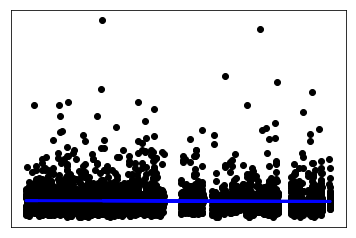

Feature # 1 : Index(['price'], dtype='object')
:::Train:::
Mean squared error: 0.00
Variance score: 1.00
:::Test:::
Mean squared error: 0.00
Variance score: 1.00


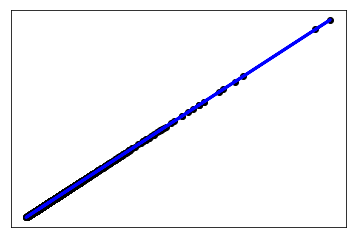

Feature # 2 : Index(['bedrooms'], dtype='object')
:::Train:::
Mean squared error: 121194382631.80
Variance score: 0.09
:::Test:::
Mean squared error: 125139326857.96
Variance score: 0.11


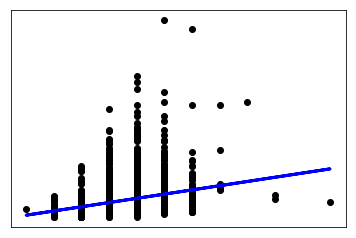

Feature # 3 : Index(['bathrooms'], dtype='object')
:::Train:::
Mean squared error: 96699440890.59
Variance score: 0.27
:::Test:::
Mean squared error: 101256970274.45
Variance score: 0.28


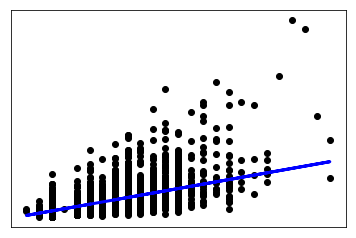

Feature # 4 : Index(['sqft_living'], dtype='object')
:::Train:::
Mean squared error: 67931066834.67
Variance score: 0.49
:::Test:::
Mean squared error: 70035987663.86
Variance score: 0.50


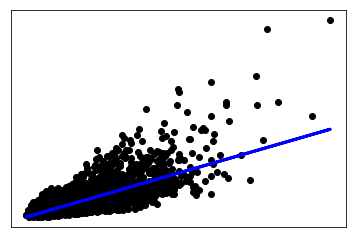

Feature # 5 : Index(['sqft_lot'], dtype='object')
:::Train:::
Mean squared error: 131991503208.02
Variance score: 0.01
:::Test:::
Mean squared error: 140515171082.82
Variance score: 0.00


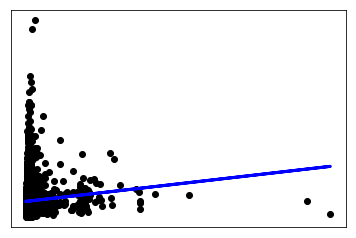

Feature # 6 : Index(['floors'], dtype='object')
:::Train:::
Mean squared error: 124476842443.80
Variance score: 0.07
:::Test:::
Mean squared error: 131543787082.01
Variance score: 0.07


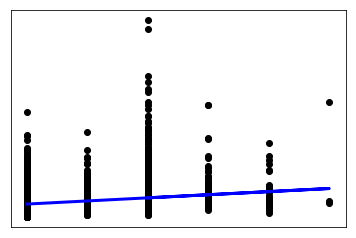

Feature # 7 : Index(['waterfront'], dtype='object')
:::Train:::
Mean squared error: 124862737682.99
Variance score: 0.06
:::Test:::
Mean squared error: 126768372724.08
Variance score: 0.10


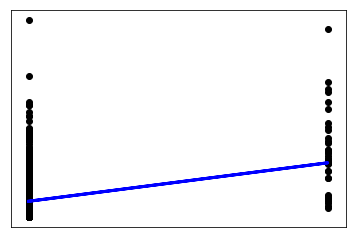

Feature # 8 : Index(['view'], dtype='object')
:::Train:::
Mean squared error: 112725044216.00
Variance score: 0.15
:::Test:::
Mean squared error: 116638273043.90
Variance score: 0.17


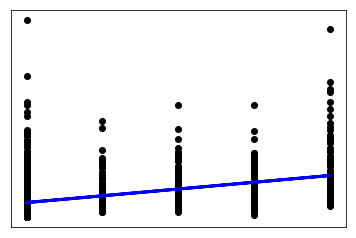

Feature # 9 : Index(['condition'], dtype='object')
:::Train:::
Mean squared error: 133028860305.53
Variance score: 0.00
:::Test:::
Mean squared error: 140893119495.79
Variance score: 0.00


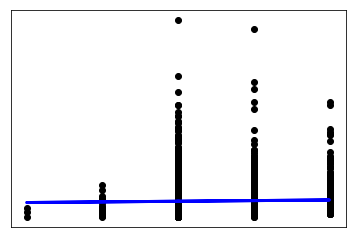

Feature # 10 : Index(['grade'], dtype='object')
:::Train:::
Mean squared error: 74169034099.19
Variance score: 0.44
:::Test:::
Mean squared error: 77021487755.19
Variance score: 0.45


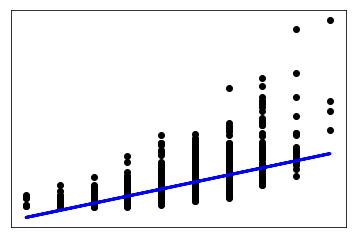

Feature # 11 : Index(['sqft_above'], dtype='object')
:::Train:::
Mean squared error: 84682285228.07
Variance score: 0.36
:::Test:::
Mean squared error: 88033383703.31
Variance score: 0.38


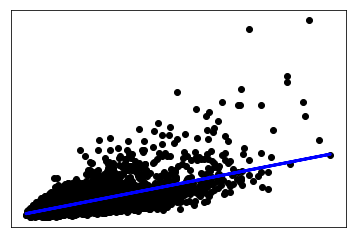

Feature # 12 : Index(['sqft_basement'], dtype='object')
:::Train:::
Mean squared error: 119221448411.21
Variance score: 0.10
:::Test:::
Mean squared error: 126338761798.45
Variance score: 0.11


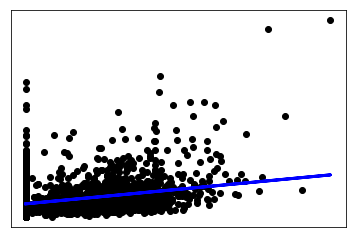

Feature # 13 : Index(['yr_built'], dtype='object')
:::Train:::
Mean squared error: 132753706875.60
Variance score: 0.00
:::Test:::
Mean squared error: 140905577064.22
Variance score: 0.00


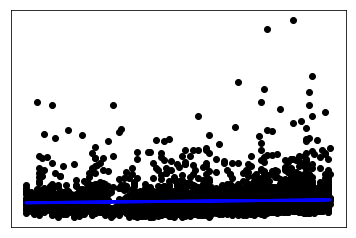

Feature # 14 : Index(['yr_renovated'], dtype='object')
:::Train:::
Mean squared error: 131666636812.28
Variance score: 0.01
:::Test:::
Mean squared error: 139681223397.51
Variance score: 0.01


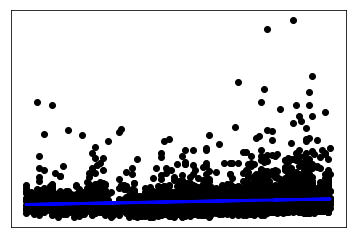

Feature # 15 : Index(['zipcode'], dtype='object')
:::Train:::
Mean squared error: 132821408885.10
Variance score: 0.00
:::Test:::
Mean squared error: 140696427223.52
Variance score: 0.00


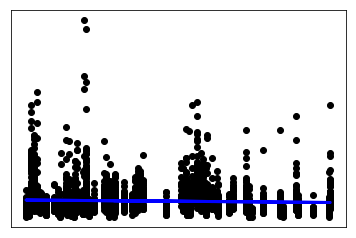

Feature # 16 : Index(['lat'], dtype='object')
:::Train:::
Mean squared error: 120412669633.00
Variance score: 0.10
:::Test:::
Mean squared error: 128725473823.62
Variance score: 0.09


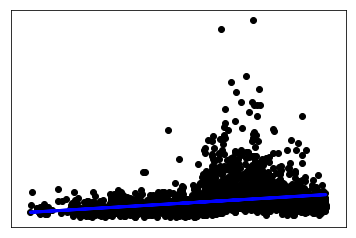

Feature # 17 : Index(['long'], dtype='object')
:::Train:::
Mean squared error: 133125346317.32
Variance score: 0.00
:::Test:::
Mean squared error: 141080155007.57
Variance score: 0.00


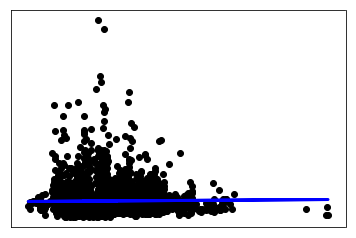

Feature # 18 : Index(['sqft_living15'], dtype='object')
:::Train:::
Mean squared error: 87878960853.00
Variance score: 0.34
:::Test:::
Mean squared error: 91447509443.09
Variance score: 0.35


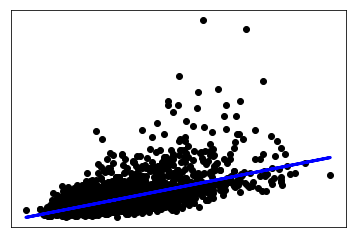

Feature # 19 : Index(['sqft_lot15'], dtype='object')
:::Train:::
Mean squared error: 132288394842.41
Variance score: 0.01
:::Test:::
Mean squared error: 140154380245.23
Variance score: 0.01


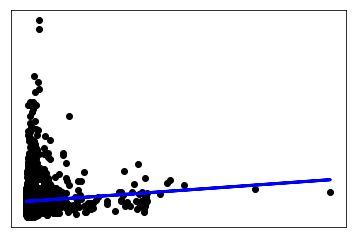

Feature # 20 : Index(['age'], dtype='object')
:::Train:::
Mean squared error: 131666636812.28
Variance score: 0.01
:::Test:::
Mean squared error: 139681223397.51
Variance score: 0.01


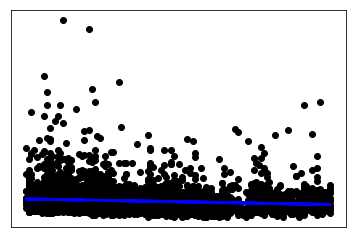

Feature # 21 : Index(['distance'], dtype='object')
:::Train:::
Mean squared error: 121885232676.85
Variance score: 0.08
:::Test:::
Mean squared error: 130229274170.52
Variance score: 0.08


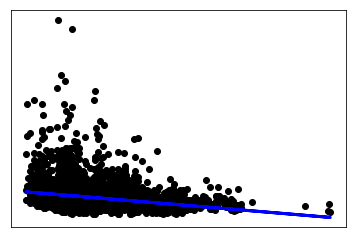

Feature # 22 : Index(['average_sqft_by_room'], dtype='object')
:::Train:::
Mean squared error: 92374071486.64
Variance score: 0.31
:::Test:::
Mean squared error: 89924352369.64
Variance score: 0.36


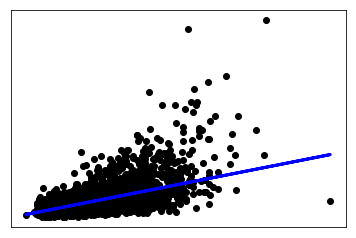

Feature # 23 : Index(['average_sqft_by_floor'], dtype='object')
:::Train:::
Mean squared error: 108239040512.49
Variance score: 0.19
:::Test:::
Mean squared error: 114777078006.67
Variance score: 0.19


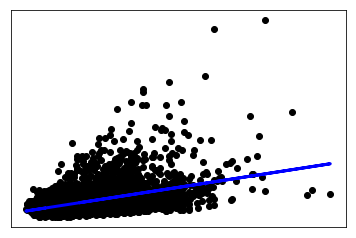

Feature # 24 : Index(['sqft_floors_mult_basement'], dtype='object')
:::Train:::
Mean squared error: 109691547528.58
Variance score: 0.18
:::Test:::
Mean squared error: 113513139756.55
Variance score: 0.20


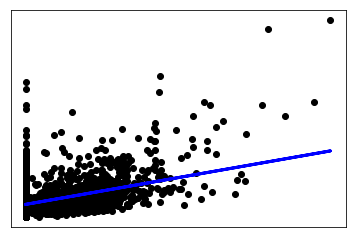

Feature # 25 : Index(['mnths'], dtype='object')
:::Train:::
Mean squared error: 133164336888.85
Variance score: 0.00
:::Test:::
Mean squared error: 141222092206.75
Variance score: -0.00


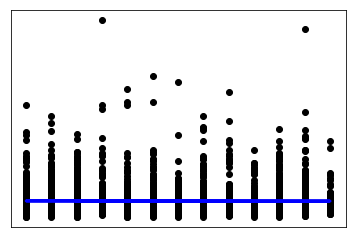

Feature # 26 : Index(['ren_living_diff'], dtype='object')
:::Train:::
Mean squared error: 111437545889.85
Variance score: 0.16
:::Test:::
Mean squared error: 117399797027.70
Variance score: 0.17


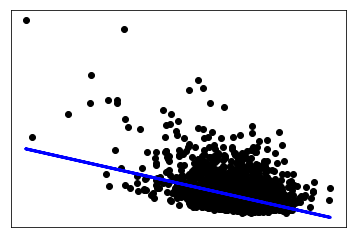

Feature # 27 : Index(['ren_lot_diff'], dtype='object')
:::Train:::
Mean squared error: 132730265997.24
Variance score: 0.00
:::Test:::
Mean squared error: 141276636949.42
Variance score: -0.00


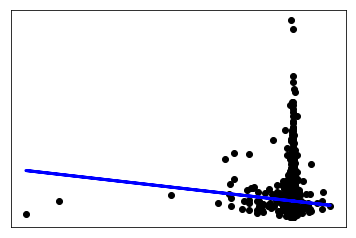

Feature # 28 : Index(['price_district'], dtype='object')
:::Train:::
Mean squared error: 131244468872.49
Variance score: 0.01
:::Test:::
Mean squared error: 138816884295.83
Variance score: 0.02


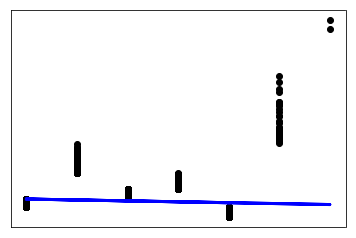

Feature # 29 : Index(['loc_district'], dtype='object')
:::Train:::
Mean squared error: 132588802128.32
Variance score: 0.00
:::Test:::
Mean squared error: 141028259144.29
Variance score: 0.00


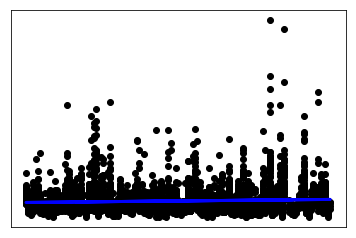

Feature # 30 : Index(['price_neigborhood'], dtype='object')
:::Train:::
Mean squared error: 133068944619.94
Variance score: 0.00
:::Test:::
Mean squared error: 141094107045.40
Variance score: 0.00


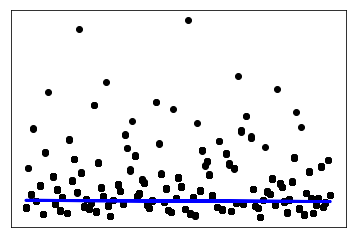

In [30]:
for x in [*range(frame.columns.size)]:
    fit_and_test_visualisation(frame, [x], 'price')

## <a name="useless_feature">Useless feature</a>

We built linear regression for target y by single x feature

Suggestion:

When variance score of linear regression by **x** feature ~0.00 and mean squared error very high* - feature useless and can't really increase variance of prediction.

very high value - for each dataset or for each target it can be difference value, but in my case big mean squared error > 140000000000. 

For exmaple:

Feature # 0 (id):
- mean squared error = 141215184926.76
- variance score = 0

**Model results with using id for features:**
- Train: Mean squared error: 35703385195.60; Variance score: 0.73;
- Test: Mean squared error: 32429380744.27; Variance score: 0.77;

**Model results without using id:**
- Train: Mean squared error: 35841752226.07; Variance score: 0.73;
- Test: Mean squared error: 32803207742.06; Variance score: 0.77;

[Back to content list](#content_list)

In [31]:
# Useless fields removing
if 'id' in frame:
    del frame['id']
if 'zipcode' in frame:
    del frame['zipcode']
if 'sqft_lot' in frame:
    del frame['sqft_lot']
if 'yr_renovated' in frame:
    del frame['yr_renovated']
if 'sqft_living15' in frame:
    del frame['sqft_living15']
if 'sqft_lot15' in frame:
    del frame['sqft_lot15']
if 'ren_lot_diff' in frame:
    del frame['ren_lot_diff']

Feature # 0 : Index(['price'], dtype='object')
:::Train:::
Mean squared error: 0.00
Variance score: 1.00
:::Test:::
Mean squared error: 0.00
Variance score: 1.00


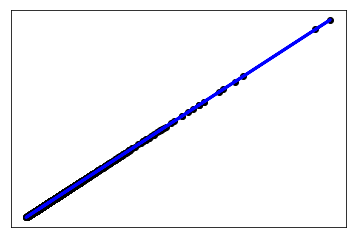

Feature # 1 : Index(['bedrooms'], dtype='object')
:::Train:::
Mean squared error: 121194382631.80
Variance score: 0.09
:::Test:::
Mean squared error: 125139326857.96
Variance score: 0.11


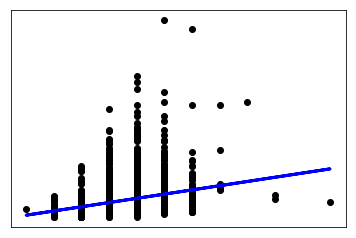

Feature # 2 : Index(['bathrooms'], dtype='object')
:::Train:::
Mean squared error: 96699440890.59
Variance score: 0.27
:::Test:::
Mean squared error: 101256970274.45
Variance score: 0.28


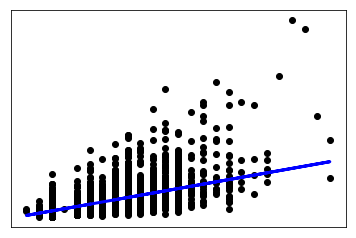

Feature # 3 : Index(['sqft_living'], dtype='object')
:::Train:::
Mean squared error: 67931066834.67
Variance score: 0.49
:::Test:::
Mean squared error: 70035987663.86
Variance score: 0.50


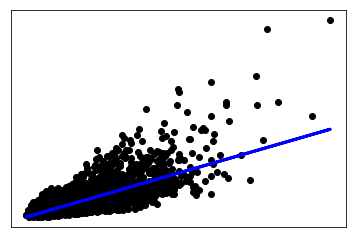

Feature # 4 : Index(['floors'], dtype='object')
:::Train:::
Mean squared error: 124476842443.80
Variance score: 0.07
:::Test:::
Mean squared error: 131543787082.01
Variance score: 0.07


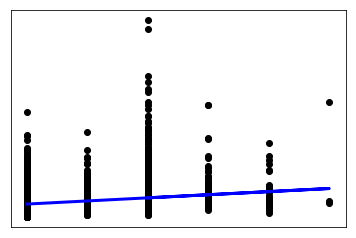

Feature # 5 : Index(['waterfront'], dtype='object')
:::Train:::
Mean squared error: 124862737682.99
Variance score: 0.06
:::Test:::
Mean squared error: 126768372724.08
Variance score: 0.10


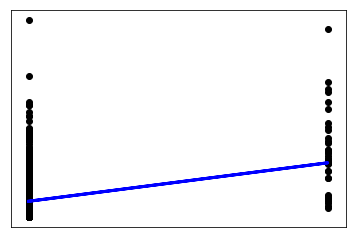

Feature # 6 : Index(['view'], dtype='object')
:::Train:::
Mean squared error: 112725044216.00
Variance score: 0.15
:::Test:::
Mean squared error: 116638273043.90
Variance score: 0.17


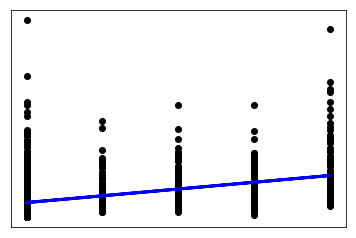

Feature # 7 : Index(['condition'], dtype='object')
:::Train:::
Mean squared error: 133028860305.53
Variance score: 0.00
:::Test:::
Mean squared error: 140893119495.79
Variance score: 0.00


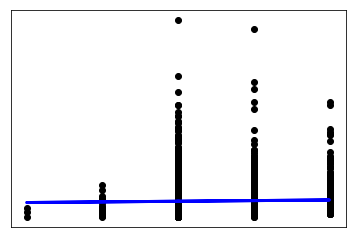

Feature # 8 : Index(['grade'], dtype='object')
:::Train:::
Mean squared error: 74169034099.19
Variance score: 0.44
:::Test:::
Mean squared error: 77021487755.19
Variance score: 0.45


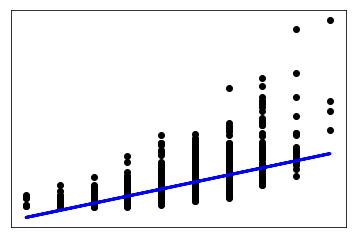

Feature # 9 : Index(['sqft_above'], dtype='object')
:::Train:::
Mean squared error: 84682285228.07
Variance score: 0.36
:::Test:::
Mean squared error: 88033383703.31
Variance score: 0.38


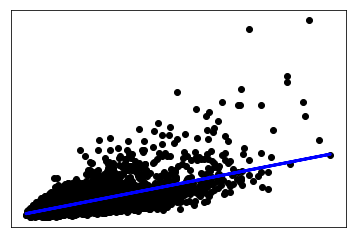

Feature # 10 : Index(['sqft_basement'], dtype='object')
:::Train:::
Mean squared error: 119221448411.21
Variance score: 0.10
:::Test:::
Mean squared error: 126338761798.45
Variance score: 0.11


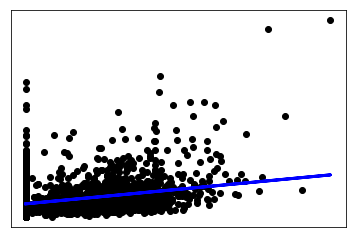

Feature # 11 : Index(['yr_built'], dtype='object')
:::Train:::
Mean squared error: 132753706875.60
Variance score: 0.00
:::Test:::
Mean squared error: 140905577064.22
Variance score: 0.00


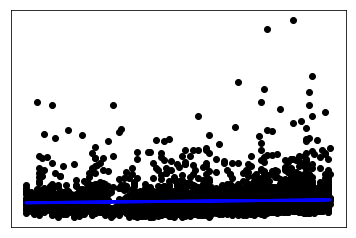

Feature # 12 : Index(['lat'], dtype='object')
:::Train:::
Mean squared error: 120412669633.00
Variance score: 0.10
:::Test:::
Mean squared error: 128725473823.62
Variance score: 0.09


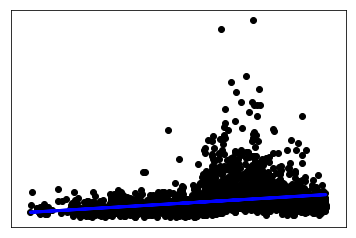

Feature # 13 : Index(['long'], dtype='object')
:::Train:::
Mean squared error: 133125346317.32
Variance score: 0.00
:::Test:::
Mean squared error: 141080155007.57
Variance score: 0.00


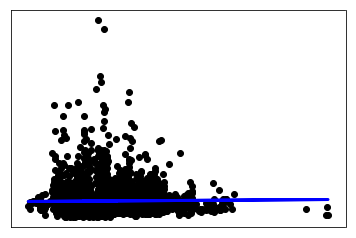

Feature # 14 : Index(['age'], dtype='object')
:::Train:::
Mean squared error: 131666636812.28
Variance score: 0.01
:::Test:::
Mean squared error: 139681223397.51
Variance score: 0.01


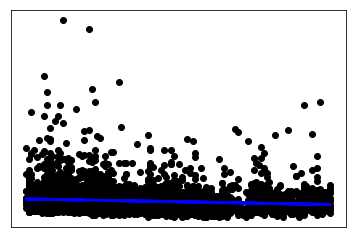

Feature # 15 : Index(['distance'], dtype='object')
:::Train:::
Mean squared error: 121885232676.85
Variance score: 0.08
:::Test:::
Mean squared error: 130229274170.52
Variance score: 0.08


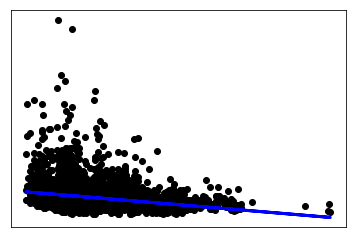

Feature # 16 : Index(['average_sqft_by_room'], dtype='object')
:::Train:::
Mean squared error: 92374071486.64
Variance score: 0.31
:::Test:::
Mean squared error: 89924352369.64
Variance score: 0.36


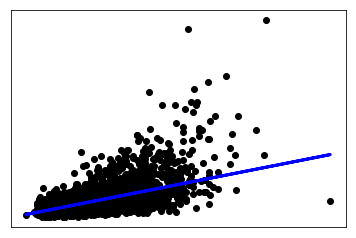

Feature # 17 : Index(['average_sqft_by_floor'], dtype='object')
:::Train:::
Mean squared error: 108239040512.49
Variance score: 0.19
:::Test:::
Mean squared error: 114777078006.67
Variance score: 0.19


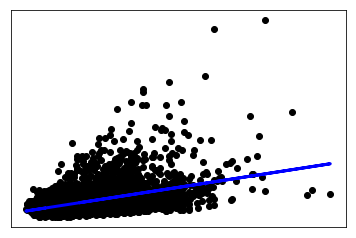

Feature # 18 : Index(['sqft_floors_mult_basement'], dtype='object')
:::Train:::
Mean squared error: 109691547528.58
Variance score: 0.18
:::Test:::
Mean squared error: 113513139756.55
Variance score: 0.20


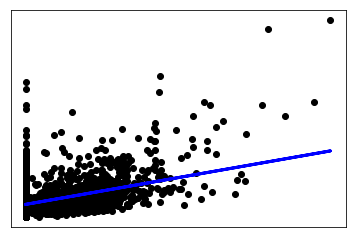

Feature # 19 : Index(['mnths'], dtype='object')
:::Train:::
Mean squared error: 133164336888.85
Variance score: 0.00
:::Test:::
Mean squared error: 141222092206.75
Variance score: -0.00


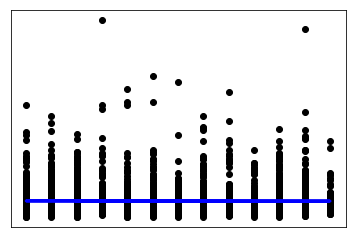

Feature # 20 : Index(['ren_living_diff'], dtype='object')
:::Train:::
Mean squared error: 111437545889.85
Variance score: 0.16
:::Test:::
Mean squared error: 117399797027.70
Variance score: 0.17


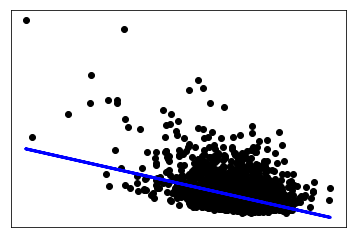

Feature # 21 : Index(['price_district'], dtype='object')
:::Train:::
Mean squared error: 131244468872.49
Variance score: 0.01
:::Test:::
Mean squared error: 138816884295.83
Variance score: 0.02


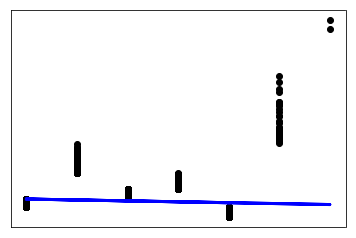

Feature # 22 : Index(['loc_district'], dtype='object')
:::Train:::
Mean squared error: 132588802128.32
Variance score: 0.00
:::Test:::
Mean squared error: 141028259144.29
Variance score: 0.00


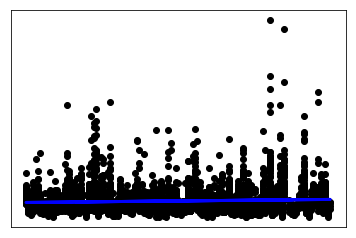

Feature # 23 : Index(['price_neigborhood'], dtype='object')
:::Train:::
Mean squared error: 133068944619.94
Variance score: 0.00
:::Test:::
Mean squared error: 141094107045.40
Variance score: 0.00


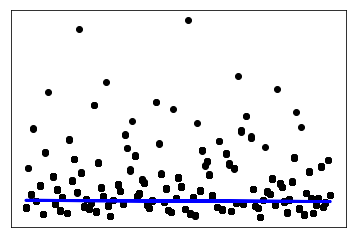

In [32]:
#visualize rest of features
for x in [*range(frame.columns.size)]:
    fit_and_test_visualisation(frame, [x], 'price')

## <a name="usefull_feature">Usefull feature</a>

I suggested, that if we created some new field with help of other fields - we can remove fields, that we used for creating new field.

But, in practice way I understood that we shouldn't remove used fields, because they further increase our varicance score in model.

For example:

**Result for linear regression with all features**

- Train: Mean squared error: 35703373173.44; Variance score: 0.73;

- Test: Mean squared error: 32786022616.10; Variance score: 0.77;

**Result for linear regression without long and lat that used for creating distance and several distincts clusters**

- Train: Mean squared error: 37793733537.16; Variance score: 0.72;

- Test: Mean squared error: 34805094308.38; Variance score: 0.75;

Lat and long - usefull features.

For other features, which even don't used for creating new field works next rule: IF we know, that feature not autogenerated as id and this feature increase variance score - we can add this feature in our list of features for linear regression.

[Back to content list](#content_list)

# <a name="lr_prediction_result">Linear regression result</a>

[Back to content list](#content_list)

In [33]:
price_index = 0
features = [*range(frame.columns.size)]
target = features[price_index]
features.remove(target)
train_features, train_target, test_features, test_target = split(frame, features, 'price')
fit_and_test(train_features, train_target, test_features, test_target)

:::Train:::
Mean squared error: 35173162696.36
Variance score: 0.74
:::Test:::
Mean squared error: 32489076781.56
Variance score: 0.77


# <a name="decision_tree">Decision tree</a>

[Back to content list](#content_list)

In [34]:
# Split data
train_features, train_target, test_features, test_target = split(frame, features, 'price')

In [35]:
# Initialize regression models
decisionTrees = []
for i in range(1, 10):
    decisionTrees.append(DecisionTreeRegressor(max_depth=i))
    
for i in range(1, 8):
    decisionTrees.append(DecisionTreeRegressor(max_depth=i*10))
len(decisionTrees)

16

In [36]:
def fit_and_visualize(trees):
    depths = []
    # fit regressions models
    for t in trees:
        t.fit(train_features, train_target)
    # Predict
    predictions = []
    for t in trees:
        predictions.append(t.predict(test_features))
    train_scores = []
    test_scores = []
    depths = []
    test_the_best_depths = 0
    max_test = 0
    train_the_best_depths = 0
    max_train = 0
    for t in trees:
        train_score = t.score(train_features,train_target)
        test_score = t.score(test_features,test_target)
        depth = t.max_depth
        depths.append(depth)
        train_scores.append(train_score)
        test_scores.append(test_score)
        if(train_score > max_train):
            max_train = train_score
            train_the_best_depths = depth
        if(test_score > max_test):
            max_test = train_score
            test_the_best_depths = depth
        print("{} level tree train score: {}".format(depth,train_score))
        print("{} level tree test score: {}\n".format(depth,test_score))
    # Visualize
    pd.DataFrame({
    'tree_depth': depths,
    'train score': train_scores,
    'test score': test_scores
    }).groupby('tree_depth').sum().plot()
    
    return train_the_best_depths, test_the_best_depths

In [37]:
#reinitialize
smallDecisionTrees = []
for i in range(1, 100):
    smallDecisionTrees.append(DecisionTreeRegressor(max_depth=i))

1 level tree train score: 0.335130380044355
1 level tree test score: 0.33836239881972596

2 level tree train score: 0.6082249048810338
2 level tree test score: 0.6054353964872751

3 level tree train score: 0.7932007683568836
3 level tree test score: 0.7805600236376644

4 level tree train score: 0.9098087780117976
4 level tree test score: 0.9068144605698603

5 level tree train score: 0.9557389269995394
5 level tree test score: 0.9461496561022238

6 level tree train score: 0.9607819924211012
6 level tree test score: 0.9464190547396254

7 level tree train score: 0.9695648832191166
7 level tree test score: 0.952542444042438

8 level tree train score: 0.9762685805573782
8 level tree test score: 0.9515580258570243

9 level tree train score: 0.9825764748654392
9 level tree test score: 0.9589335567117033

10 level tree train score: 0.9891157748813941
10 level tree test score: 0.964148286692496

11 level tree train score: 0.993141409625321
11 level tree test score: 0.9650608960352373

12 level 

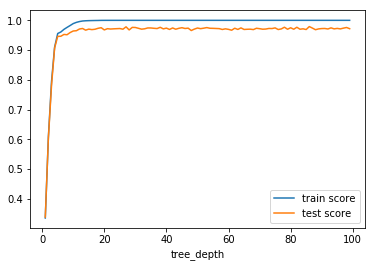

In [38]:
train_the_best_depths, test_the_best_depths = fit_and_visualize(smallDecisionTrees)

In [39]:
print("The best train depth: {}".format(train_the_best_depths))
print("The best test depth: {}".format(test_the_best_depths))

The best train depth: 35
The best test depth: 9


# <a name="dt_result">Decision tree result</a>

How we can see, the best depth for decision tree almost always > than depth for test depth, because when we have really deep tree, this tree just "knows" all cases in train dataset and become retrained.

When we use retrained desicion tree for test dataset, which differend from train - this train has low accuracy.

[Back to content list](#content_list)

# <a name="summary">Summary</a>

I think, that I achieved good accuracy, because all my features based on attantive data analysis:
 - Each column from data frame was analysed by feature:target linear regression which in my opinion very good show us feature usefulness for price target
 - Was added custom parameters which based on parameters from frame

But, it can be better, because:
 - I bad analysed data feature 
 - The same with floors and coordinates

**Linear regression:**
- Train: Mean squared error: 35173162696.36; Variance score: 0.74;
- Test: Mean squared error: 32489076781.56; Variance score: 0.77;

[Back to content list](#content_list)